### Gives for the location where the bulk of snow is advected the reflectivities at this bin

In [75]:
import datetime as dt
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
import h5py
# not working here, why? Ask Kai
#import eccodes as codes
#import miub_eccodes as mecc

from scipy import stats
from scipy import ndimage
import glob
import os
import math
import pandas as pd

import psutil
process = psutil.Process(os.getpid())

In [76]:
import wradlib as wrl
import numpy as np
import matplotlib.pyplot as pl

In [77]:
def iround(x):
    """iround(number) -> integer
    Round a number to the nearest integer."""
    return int(round(x) - .5) + (x > 0)

In [78]:
def _shape2size(shape):
    """
    Compute the size which corresponds to a shape
    """
    out = 1
    for item in shape:
        out *= item
    return out

def _get_func(funcname):
    """
    Retrieve the numpy function with name <funcname>
    Parameters
    ----------
    funcname : string
    """
    try:
        func = getattr(np, funcname)
    except AttributeError:
        raise AttributeError('<' + funcname +
                             '> is not a valid function in numpy...')
    return func

def aggregate_in_time(src, dt_src, dt_trg, taxis=0, func='sum'):
    """Aggregate time series data to a coarser temporal resolution.
    Parameters
    ----------
    src : :class:`numpy:numpy.ndarray`
        Array of shape (..., original number of time steps,...)
        This is the time series data which should be aggregated. The position
        of the time dimension is indicated by the *taxis* argument. The number
        of time steps corresponds to the length of the time dimension.
    taxis : integer
        This is the position of the time dimension in array *src*.
    dt_src : :class:`numpy:numpy.ndarray`
        Array of datetime objects
        Must be of length *original number of time steps + 1* because dt_src
        defines the limits of the intervals corresponding to the time steps.
        This means: dt_src[0] is the lower limit of time step 1, dt_src[1] is
        the upper limit of time step 1 and the lower limit of time step 2 and
        so on.
    dt_trg : :class:`numpy:numpy.ndarray`
        Array of datetime objects
        Must be of length *number of output time steps + 1* analogously to
        dt_src. This means: dt_trg[0] is the lower limit of output time step 1,
        dt_trg[1] is the upper limit of output time step 1 and the lower limit
        of output time step 2 and so on.
    func : str
        numpy function name, e.g. 'sum', 'mean'
        Defines the way the data should be aggregated. The string must
        correspond to a valid numpy function, e.g. 'sum', 'mean', 'min', 'max'.
    Returns
    -------
    output : :class:`numpy:numpy.ndarray`
        Array of shape (..., len(dt_trg) - 1, ...)
        The length of the time dimension of the output array depends on the
        array *dt_trg* which defines the limits of the output time step
        intervals.
    Examples
    --------
    >>> src = np.arange(8 * 4).reshape((8, 4))
    >>> print('source time series:') #doctest: +SKIP
    >>> print(src)
    [[ 0  1  2  3]
     [ 4  5  6  7]
     [ 8  9 10 11]
     [12 13 14 15]
     [16 17 18 19]
     [20 21 22 23]
     [24 25 26 27]
     [28 29 30 31]]
    >>> dt_src = [dt.datetime.strptime('2008-06-02', '%Y-%m-%d' ) + \
    dt.timedelta(hours=i) for i in range(9)]
    >>> print('source time interval limits:') #doctest: +SKIP
    >>> for tim in dt_src: print(tim)
    2008-06-02 00:00:00
    2008-06-02 01:00:00
    2008-06-02 02:00:00
    2008-06-02 03:00:00
    2008-06-02 04:00:00
    2008-06-02 05:00:00
    2008-06-02 06:00:00
    2008-06-02 07:00:00
    2008-06-02 08:00:00
    >>> print('target time interval limits:') #doctest: +SKIP
    >>> dt_trg = [dt.datetime.strptime('2008-06-02', '%Y-%m-%d' ) + \
    dt.timedelta(seconds=i*3600*4) for i in range(4)]
    >>> for tim in dt_trg: print(tim)
    2008-06-02 00:00:00
    2008-06-02 04:00:00
    2008-06-02 08:00:00
    2008-06-02 12:00:00
    >>> print('target time series') #doctest: +SKIP
    >>> agg = aggregate_in_time(src, dt_src, dt_trg, taxis=0, func='sum')
    >>> print(agg) # doctest: +NORMALIZE_WHITESPACE
    [[  24.   28.   32.   36.]
     [  88.   92.   96.  100.]
     [  nan   nan   nan   nan]]
    See :ref:`notebooks/basics/wradlib_workflow.ipynb#Rainfall-accumulation`.
    """
    # src, dt_src, dt_trg = np.array(src), np.array(dt_src), np.array(dt_trg)
    dt_src, dt_trg = np.array(dt_src), np.array(dt_trg)
    trg_shape = list(src.shape)
    trg_shape[taxis] = len(dt_trg) - 1
    trg = np.repeat(np.nan, _shape2size(trg_shape)).reshape(trg_shape)
    for i in range(len(dt_trg) - 1):
        trg_slice = [slice(0, j) for j in trg.shape]
        trg_slice[taxis] = i
        src_slice = [slice(0, src.shape[j]) for j in range(len(src.shape))]
        src_slice[taxis] = np.where(
            np.logical_and(dt_src <= dt_trg[i + 1],
                           dt_src >= dt_trg[i]))[0][:-1]
        if len(src_slice[taxis]) == 0:
            trg[trg_slice] = np.nan
        else:
            trg[trg_slice] = _get_func(func)(src[tuple(src_slice)], axis=taxis)
    return trg

In [79]:
def get_coordinates(x, y, z, site):
    re = wrl.georef.get_earth_radius(site[1])
    
    rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                        '+lat_0={lat:f} +ellps=WGS84 +datum=WGS84 ' +
                        '+units=m +no_defs').format(lon=site[0],
                                                    lat=site[1]))
    stack = np.stack((x,y,z), axis=-1)
    if stack.ndim == 1:
        stack = stack[None, :]
        
    r, phi, theta = wrl.georef.xyz_to_spherical(stack, alt=site[2], proj=rad)
    
    spherical = np.stack((r, phi, theta), axis=-1)
    lla = wrl.georef.reproject(stack, projection_source=rad)
    
    
    return spherical, lla

In [80]:
# Radar Bonn
site = (7.071626, 50.730554, 99.5)

In [81]:
# Zur Veranschaulichung, es geht auch mit Feldern
x = np.array([5000, 6000])
y = np.array([5000, 6000])
z = np.array([1000, 2000])
spherical, lla = get_coordinates(x, y, z, site)
print(spherical)
print(lla)

[[7.12863064e+03 4.50000000e+01 7.23321407e+00]
 [8.69653410e+03 4.50000000e+01 1.25943776e+01]]
[[   7.14251187   50.7754789  1000.        ]
 [   7.15670534   50.78445866 2000.        ]]


In [82]:
#Hier als Beispiel mit jeweils einem x,y, und z-Wert, geht aber auch mit obigen Feldern
#2015-03-29   76202.9    8880.8   76718.7     982.0 
#2014-08-26   30837.5    -897.3   30850.6    2310.0 
#2015-09-01   21465.1   29753.5   36688.2    2351.0 
#2015-08-27   53711.0   32202.6   62624.9    2980.0 
#2015-05-03   30720.0   14488.0   33965.0    2959.0 

#2013-04-12   33893.3   13043.5   36316.5    1325.0 #super event
#2014-05-27  -20237.9    5552.0   20985.7    2086.0 
#2014-07-08   11988.4   -5645.6   13251.2    2507.0 
#2014-11-16     654.7    1789.4    1905.4    1351.0 
#2014-10-07   17499.9   31357.0   35909.7    2056.0 
#2014-05-06   23673.2   31830.2   39668.4    1855.0 
#2014-07-08   11988.4   -5645.6   13251.2    2507.0 
#2014-11-04   25046.7   42689.9   49495.1    1083.0
#2015-08-17   -6254.6    5859.4    8570.5    3054.0
#2015-12-08   27075.1   39008.6   47484.0    1576.0

spherical, lla = get_coordinates(27075.1, 39008.6, 1576.0 , site)

#slant range, azimuth and elevation angle
print(spherical)
binnr=iround(spherical[0,0]/100.)
azimuth=iround(spherical[0,1])
print('bin',binnr)
print('azi',azimuth)
#Koordinaten, Hohe unverand
print(lla)
lonloc=lla[0,0]
latloc=lla[0,1]
print('lonloc',lonloc)
print('latloc',latloc)

[[4.75115903e+04 3.47637524e+01 1.62055979e+00]]
('bin', 475)
('azi', 35)
[[   7.45799283   51.08056789 1576.        ]]
('lonloc', 7.457992831106952)
('latloc', 51.08056788622171)


# Reads the radar data for the day of interest

In [93]:
"""
-----------------------------------------------------------------
 global data    
-----------------------------------------------------------------
"""
# this defines start and end time
# need to be within the same day

#start_time = dt.datetime(2015, 3, 29, 9, 00)
#Mach jetzt immer noch drei Stunden laenger
#end_time = dt.datetime(2015, 3, 29, 16, 20)

#start_time = dt.datetime(2014, 8, 26, 12, 30)
#Mach jetzt immer noch drei Stunden laenger
#end_time = dt.datetime(2014, 8, 26, 21, 35)

#start_time = dt.datetime(2015, 9, 1, 4, 40)
#Mach jetzt immer noch drei Stunden laenger
#end_time = dt.datetime(2015, 9, 1, 14, 15)

#start_time = dt.datetime(2015, 8, 27, 13, 00)
#Hier nur 1h und 5 min laenger moeglich
#end_time = dt.datetime(2015, 8, 27, 23, 55)

#start_time = dt.datetime(2015, 5, 3, 12, 55)
#Mach jetzt immer noch drei Stunden laenger
#end_time = dt.datetime(2015, 5, 3, 20, 00)

# Super Case
#start_time = dt.datetime(2013, 4, 12, 00, 10)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2013, 4, 12, 4, 10)
#end_time = dt.datetime(2013, 4, 12, 7, 10)

#start_time = dt.datetime(2014, 5, 6, 18, 30)
#Mach jetzt immer noch drei Stunden laenger
#end_time = dt.datetime(2014, 5, 6,23, 55)

#start_time = dt.datetime(2014, 5, 27, 00, 30)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 5, 27, 5, 00)
#end_time = dt.datetime(2014, 5, 27, 8, 00)

#start_time = dt.datetime(2014, 7, 8, 00, 30)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 7, 8, 5, 00)
#end_time = dt.datetime(2014, 7, 8, 8, 00)

#start_time = dt.datetime(2014, 11, 16, 00, 00)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 11, 16, 9, 20)
#end_time = dt.datetime(2014, 11, 16, 12, 20)

#start_time = dt.datetime(2014, 10, 7, 00, 00)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 10, 7, 3, 25)
#end_time = dt.datetime(2014, 10, 7, 6, 25)

#start_time = dt.datetime(2014, 5, 6, 18, 30)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 5, 6,23, 25)
#end_time = dt.datetime(2014, 5, 7, 2, 25)

#start_time = dt.datetime(2014, 7, 8, 19, 00)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 7, 8, 23, 55)
#end_time = dt.datetime(2014, 7, 9, 2, 55)

#start_time = dt.datetime(2014, 11, 4, 12, 00)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2014, 11, 4, 23, 00)
#end_time = dt.datetime(2014, 11, 5, 2, 00)

#start_time = dt.datetime(2015, 8, 17, 16, 35)
#Mach jetzt immer noch drei Stunden laenger
#end_time1 = dt.datetime(2015, 8, 17, 22, 15)
#end_time = dt.datetime(2015, 8, 18, 2, 15)

start_time = dt.datetime(2015, 12, 8, 20, 15)
#Mach jetzt immer noch drei Stunden laenger
end_time1 = dt.datetime(2015, 12, 8, 23, 50)
end_time = dt.datetime(2015, 12, 9, 2, 50)


    
date = '{0}-{1:02d}-{2:02d}'.format(start_time.year, start_time.month, start_time.day)
print('date',date)
location = 'Bonn'
radar_path='/automount/radar/scans/{0}/{0}-{1:02}/{2}'.format(start_time.year, start_time.month, date)
#radar_path ='/automount/radar-archiv/scans/{0}/{0}-{1:02}/{2}'.format(start_time.year, start_time.month, date)
if (end_time.day - start_time.day):
    date_next_day = '{0}-{1:02d}-{2:02d}'.format(end_time.year, end_time.month, end_time.day)
    #radar_path_next_day = '/automount/radar-archiv/scans/{0}/{0}-{1:02}/{2}'.format(end_time.year, end_time.month, date_next_day)
    radar_path_next_day = '/automount/radar/scans/{0}/{0}-{1:02}/{2}'.format(end_time.year, end_time.month, date_next_day)
else:
    radar_path_next_day = None
#radar_path='/home/silke/Python/testdata/{0}'.format(date)
output_path = '../../surfaceZh'
print('radar_path', radar_path)
print('output_path', output_path)
# choose scan
file_path = radar_path + '/' + 'n_ppi_010deg/'
if radar_path_next_day:
    file_path_next_day = radar_path_next_day + '/' + 'n_ppi_010deg/'
#file_path = radar_path + '/' + 'ppi_1p5deg/'
#file_path = radar_path + '/' + 'n_ppi_045deg'

textfile_path = output_path + '/{0}/textfiles/'.format(date)
plot_path = output_path + '/{0}/plots/'.format(date)

print(radar_path)
print(output_path)
print(textfile_path)
print(plot_path)

# create paths accordingly
if not os.path.isdir(output_path):
    os.makedirs(output_path)
if not os.path.isdir(textfile_path):
    os.makedirs(textfile_path)
if not os.path.isdir(plot_path):
    os.makedirs(plot_path)

plot_width = 9
plot_height = 7.2

offset_z = 3
offset_phi = 85
offset_zdr = 0.7

special_char = ":"

('date', '2015-12-08')
('radar_path', '/automount/radar/scans/2015/2015-12/2015-12-08')
('output_path', '../../surfaceZh')
/automount/radar/scans/2015/2015-12/2015-12-08
../../surfaceZh
../../surfaceZh/2015-12-08/textfiles/
../../surfaceZh/2015-12-08/plots/


In [94]:
class boxpol(object):
    """
    reads data from hdf5-file
    gelesen werden die Daten zh,phi,rho,zdr mit Zeitstempel.
    Mit der Rückgabe von no_file=0 wird zum Ausdruck gebracht, dass
    die Datei korrekt gelesen werden konnte.

    Im Fehlerfall (Rückgabe n0_file=1) werden Dummy-Daten returniert und
    auf den Bildschirm der Name der nicht gefundenen Datei ausgegeben.
    """
    def __init__(self, filename, **kwargs):
        data = read_generic_hdf5(filename)
        #data, meta = wrl.io.read_gamic_hdf5(filename)
        #print('keys', meta['SCAN0'].keys())
        #print(data)
        #exit(9)
        if data is not None:
            self._zh = transform(data['scan0/moment_10']['data'],
                           data['scan0/moment_10']['attrs']['dyn_range_min'],
                           data['scan0/moment_10']['attrs']['dyn_range_max'],
                           data['scan0/moment_10']['attrs']['format'])

            self._phi = transform(data['scan0/moment_1']['data'],
                            data['scan0/moment_1']['attrs']['dyn_range_min'],
                            data['scan0/moment_1']['attrs']['dyn_range_max'],
                            data['scan0/moment_1']['attrs']['format'])

            self._rho = transform(data['scan0/moment_2']['data'],
                            data['scan0/moment_2']['attrs']['dyn_range_min'],
                            data['scan0/moment_2']['attrs']['dyn_range_max'],
                            data['scan0/moment_2']['attrs']['format'])

            self._zdr = transform(data['scan0/moment_9']['data'],
                            data['scan0/moment_9']['attrs']['dyn_range_min'],
                            data['scan0/moment_9']['attrs']['dyn_range_max'],
                            data['scan0/moment_9']['attrs']['format'])

            self._vel = transform(data['scan0/moment_5']['data'],
                    data['scan0/moment_5']['attrs']['dyn_range_min'],
                    data['scan0/moment_5']['attrs']['dyn_range_max'],
                    data['scan0/moment_5']['attrs']['format'])

            self._radar_height = data['where']['attrs']['height']

            self._range_samples = data['scan0/how']['attrs']['range_samples']
            self._range_step = data['scan0/how']['attrs']['range_step']
            self._bin_count = data['scan0/how']['attrs']['bin_count']
            self._elevation = data['scan0/how']['attrs']['elevation']
            
            self._azi_start = data['scan0/ray_header']['data']['azimuth_start']

            try:
                self._date = dt.datetime.strptime(data['scan0/how']['attrs']['timestamp'].decode(), '%Y-%m-%dT%H:%M:%SZ')
            except:
                self._date = dt.datetime.strptime(data['scan0/how']['attrs']['timestamp'].decode(), '%Y-%m-%dT%H:%M:%S.000Z')

    @property
    def zh(self):
        """ Returns DataSource
        """
        return self._zh

    @zh.setter
    def zh(self, value):
        self._zh = value

    @property
    def phi(self):
        """ Returns DataSource
        """
        return self._phi

    @phi.setter
    def phi(self, value):
        self._phi = value

    @property
    def rho(self):
        """ Returns DataSource
        """
        return self._rho

    @rho.setter
    def rho(self, value):
        self._rho = value

    @property
    def zdr(self):
        """ Returns DataSource
        """
        return self._zdr

    @zdr.setter
    def zdr(self, value):
        self._zdr = value

    @property
    def date(self):
        """ Returns DataSource
        """
        return self._date

    @property
    def radar_height(self):
        """ Returns DataSource
        """
        return self._radar_height

    @property
    def range_step(self):
        """ Returns DataSource
        """
        return self._range_step

    @property
    def bin_count(self):
        """ Returns DataSource
        """
        return self._bin_count

    @property
    def range_samples(self):
        """ Returns DataSource
        """
        return self._range_samples

    @property
    def elevation(self):
        """ Returns DataSource
        """
        return self._elevation
    
    @property
    def azi_start(self):
        """ Returns DataSource
        """
        return self._azi_start



In [95]:
def read_generic_hdf5(fname):
    """Reads hdf5 files according to their structure

    In contrast to other file readers under wradlib.io, this function will 
    *not* returnreturn a two item tuple with (data, metadata). Instead, this 
    function returns ONE a dictionary that contains all the file contents - 
    both data and metadata. The keys of the output dictionary conform to the 
    Group/Subgroup directory branches of the original file.

    Parameters
    ----------
    fname : string (a hdf5 file path)

    Returns
    -------
    output : a dictionary that contains both data and metadata according to the
              original hdf5 file structure

    """
    f = h5py.File(fname, "r")
    fcontent = {}

    def filldict(x, y):
        # create a new container
        tmp = {}
        # add attributes if present
        if len(y.attrs) > 0:
            tmp['attrs'] = dict(y.attrs)
        # add data if it is a dataset
        if isinstance(y, h5py.Dataset):
            tmp['data'] = np.array(y)
        # only add to the dictionary, if we have something meaningful to add
        if tmp != {}:
            fcontent[x] = tmp

    f.visititems(filldict)

    f.close()
    return fcontent


In [96]:
def transform(data, dmin, dmax, dformat):
    """
    transforms the raw data to the dynamic range [dmin,dmax]
    """

    if dformat == 'UV8':
        dform = 255
    else:
        dform = 65535
    # or even better: use numpy arrays, which removes need of for loops
    t = dmin + data * (dmax - dmin) / dform
    return t


# -----------------------------------------------------------------

In [97]:
# finally reads the data
"""
-----------------------------------------------------------------
main program
-----------------------------------------------------------------
"""
t1 = dt.datetime.now()

print("fpath:", file_path)
print("fpath:", file_path_next_day)
file_names = sorted(glob.glob(os.path.join(file_path, '*mvol')))
#print("file_names1", (file_names))
if radar_path_next_day:
    print('in if')
    file_names.extend(sorted(glob.glob(os.path.join(file_path_next_day, '*mvol'))))

#print("file_names2",(file_names))

# get some specifics of the radar data
ds0 = boxpol(file_names[0])
bin_range = ds0.range_samples * ds0.range_step
bin_count = ds0.bin_count
range_bin_dist = np.arange(bin_range/2, bin_range*bin_count+1, bin_range)
elevation = ds0.elevation
# get bins, azi from fist file
(azi, bins) = ds0.zh.shape
print('azi, bins, elevation', azi, bins, elevation)

#print('file_names',file_names)
 
file_list = []
time_list = []
for fname in file_names:
    #print(fname)
    time = dt.datetime.strptime(os.path.splitext(os.path.basename(fname))[0], "%Y-%m-%d--%H:%M:%S,%f")
    if time >= start_time and time <= end_time:
        file_list.append(fname)
        time_list.append(time)


file_names = file_list
n_files = len(file_names)

#print('n_files', n_files)
# define result arrays
zh2 = np.zeros((azi, bins))
zh_at_loc = np.zeros(n_files)
result_azi= np.zeros(azi)
result_data_zh = np.zeros((n_files, azi, bins))
result_data_phi = np.zeros((n_files, azi, bins))
result_data_rho = np.zeros((n_files, azi, bins))
result_data_zdr = np.zeros((n_files, azi, bins))

# -----------------------------------------------------------------
dt_src = []  # list for time stamps
# -----------------------------------------------------------------

# iterate over files and read data files
out_file2= open(textfile_path + 'ZH_at_Loc.dat',"w")
out_file2.write("Surface ZH at advected location (timesteps= 5 min)\n")
for n, fname in enumerate(file_names):
    #print("FILENAME:", fname)

    dsl = boxpol(fname)

    #print(dsl.date)
    #print("ZH:", dsl.zh.shape)
    #print("RES:", result_data_zh.shape)
    #print("---------> Reading finished")

    # add the offset
    dsl.zh += offset_z
    dsl.phi += offset_phi
    dsl.zdr += offset_zdr
    
    mask = np.where(dsl.zh<0)
    dsl.zh[mask]= np.nan
    #print('azi_start', type(dsl.azi_start), dsl.azi_start.shape, dsl.azi_start)
    #jetzt den Azimuth richtig drehen
    result_azi=dsl.azi_start.astype(int)
    zh2[result_azi,:] = dsl.zh[:,:]
    # noise reduction for rho_hv
    
    noise_level = -22
    # vorher -23, -22 probiert zu hohen rho
    #genommen fuer 2014-08-26
    # fuer Florian angegeben noise_level = -23
    # noise_level = -32
    # aendern
    snr = np.zeros((azi, bins))
    # snr = np.zeros((360,1000))


    for i in range(azi):
        snr[i, :] = dsl.zh[i, :] - 20 * np.log10(range_bin_dist * 0.001) - noise_level - \
                    0.033 * range_bin_dist / 1000
    dsl.rho = dsl.rho * np.sqrt(1. + 1. / 10. ** (snr * 0.1))

    
    
    #result_data_zh[n, ...] = dsl.zh
    result_data_zh[n, ...] = zh2
    result_data_phi[n, ...] = dsl.phi
    result_data_rho[n, ...] = dsl.rho
    result_data_zdr[n, ...] = dsl.zdr
    radar_height = dsl.radar_height
    dt_src.append(dsl.date)
    
    time_truncated = time_list[n].strftime("%H, %M")
    #print('dates0',time_truncated)
    zh_at_loc[n]=np.nanmean(result_data_zh[n,azimuth-2:azimuth+2,binnr-10:binnr+10])
    out_file= open(textfile_path + "Laggedcorr.dat","w")
    out_file2.write("%6s %7.2f\n" % (time_truncated, zh_at_loc[n]))
datepath='/home/silke/Python/projects/climatology/'
in_file1= open(datepath + "Retriev_" + date + ".txt","r")
    #print(in_file2)
data1 =np.loadtxt(in_file1, skiprows=1, usecols=range(1,5,1), dtype = 'f4')
ICW_D=data1[:,2]
ICW_D2=data1[:,3]
in_file2= open(datepath + "Erika_" + date + ".txt","r")
data2 =np.loadtxt(in_file2, skiprows=1, usecols=range(1,4,1), dtype = 'f4')
in_file1.close()
in_file2.close()
KDP_D=data2[:,0]
######check what is needed
IWC_D=data1[:,2]
R_IWC_D=IWC_D*3.7
IWC2_D=data1[:,3]
R_IWC2_D=IWC2_D*3.7
######
print('len KDP',len(KDP_D))
print('len zh',len(zh_at_loc[0:len(KDP_D)]))

claw='pearson'
#claw='spearman'
#claw='kendall'
highcorr=-1.
highlag=0
out_file= open(textfile_path + 'Laggedcorr.dat',"w")
out_file.write("Pearson for lags from 0 to 24 (timesteps= 5 min)\n")

Kdp_D_mask=np.where(KDP_D <= 0 )
KDP_D[Kdp_D_mask]=np.nan
#######################################
for i in range(24):
    c = np.vstack((KDP_D, zh_at_loc[i:len(KDP_D)+i]))
    #print(c.shape)
    df = pd.DataFrame(c.T, columns=['KDP_D', 'zh_at_loc'])
    c_KDP_D_zh_at_loc=df.corr(method=claw).as_matrix()[1,0]
    if c_KDP_D_zh_at_loc > highcorr:
        highcorr = c_KDP_D_zh_at_loc
        highlag = i
    print('Lag','Pearson', i, c_KDP_D_zh_at_loc)
    out_file.write("%6s %7.2f\n" % (i, c_KDP_D_zh_at_loc))
    
out_file.close()
out_file2.close()

('fpath:', '/automount/radar/scans/2015/2015-12/2015-12-08/n_ppi_010deg/')
('fpath:', '/automount/radar/scans/2015/2015-12/2015-12-09/n_ppi_010deg/')
in if
('azi, bins, elevation', 360, 1000, 0.999755859375)


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice


('len KDP', 44)
('len zh', 44)
('Lag', 'Pearson', 0, -0.8206766020373409)
('Lag', 'Pearson', 1, -0.7408294104107647)
('Lag', 'Pearson', 2, -0.6296071788953562)
('Lag', 'Pearson', 3, -0.4518143254818105)
('Lag', 'Pearson', 4, -0.26687776308000605)
('Lag', 'Pearson', 5, -0.1748343806423455)
('Lag', 'Pearson', 6, -0.11444831517676833)
('Lag', 'Pearson', 7, -0.08286110124309473)
('Lag', 'Pearson', 8, 0.00410342506404088)
('Lag', 'Pearson', 9, 0.17118733788267287)
('Lag', 'Pearson', 10, 0.26832818872629743)
('Lag', 'Pearson', 11, 0.35816376405689937)
('Lag', 'Pearson', 12, 0.3096729932789122)
('Lag', 'Pearson', 13, 0.147640360017875)
('Lag', 'Pearson', 14, -0.043579299432482156)
('Lag', 'Pearson', 15, -0.05459246138698424)
('Lag', 'Pearson', 16, -0.10401314434012252)
('Lag', 'Pearson', 17, -0.21308021255853868)
('Lag', 'Pearson', 18, -0.14094490462639095)
('Lag', 'Pearson', 19, -0.08061807646734141)
('Lag', 'Pearson', 20, -0.009091033548711177)
('Lag', 'Pearson', 21, 0.1664766329026007)
('L

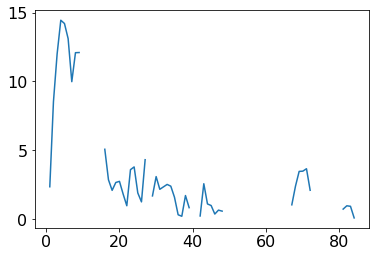

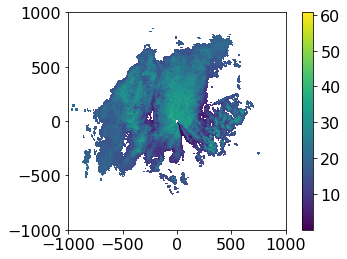

In [98]:
pl.plot(result_data_zh[0,135,:])
#wrl.vis.plot_cg_ppi(result_data_zh[1,:,:])
#wrl.vis.plot_cg_ppi(dsl.zh)
ax, pm= wrl.vis.plot_ppi(result_data_zh[24,:,:])
cb = pl.colorbar(pm, ax=ax)

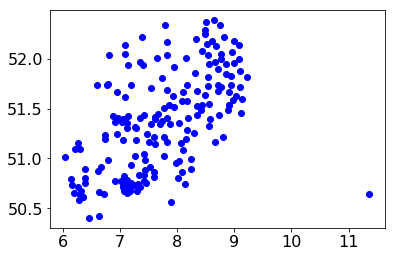

In [99]:
import numpy as np
import pandas
import csv

# load csv data via numpy.loadtxt
# fastest method but uncomfortable

filename = os.path.join('/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations', 'LUA-Stationen2_Bonn.csv')

# create datatype of data to be read
meta_type = np.dtype({'names': ['Station',  'Geogr.Laenge', 'Geogr.Breite'],
                'formats': ['|S32', np.float, np.float]})

# load data with some definitions
meta = np.loadtxt(filename, delimiter=',', usecols=[3,6,7], unpack=False, dtype=meta_type, skiprows=0,
                  converters={0: lambda s: float(s.strip() or 0)})
                  
#print(meta)
#print(meta.dtype)
fig, ax = pl.subplots()
for st, lon, lat in meta:
    ax.plot(lon, lat, marker='o', color='b', label=st)
pl.show()


In [101]:
from matplotlib.path import Path
####################Ist mir nicht klar, ich tu jetzt so als wäre das Radar woanders
f='/home/silke/Python/projects/climatology/2016-04-12--11:20:00,00.mvol'
rdata, rmeta = wrl.io.read_gamic_hdf5(f)
#print(rmeta)
r = rmeta['SCAN0']['r']
#beim Supercase mit 8100 m Entfernung
#r=np.arange(100,8100,100)
#beim low-wind case mal mit 4100 m Entferningr=np.arange(100,8100,100)
#beim 7-10-14 mit 9100
r=np.arange(100,12100,100)
#print(r)
az = rmeta['SCAN0']['az']
el = rmeta['SCAN0']['el']
sitecoords = (lonloc, latloc, 99.5)
print(sitecoords)
proj_radar = wrl.georef.create_osr("aeqd", lat_0=sitecoords[1],
                               lon_0=sitecoords[0])
radius = wrl.georef.get_earth_radius(sitecoords[1], proj_radar)

proj_wgs = wrl.georef.get_default_projection()

coords = wrl.georef.spherical_to_centroids(r, az, el, sitecoords, proj=proj_wgs)
cent_lon = coords[..., 0]
cent_lat = coords[..., 1]
cent_alt = coords[..., 2]

############################################
x = np.array([m[1] for m in meta])
y = np.array([m[2] for m in meta])
station = np.array([m[0] for m in meta])
points = np.squeeze(np.dstack((x,y)))
vertices = np.squeeze(np.dstack((cent_lon[:,-1], cent_lat[:,-1])))
pth = Path(vertices)

contains = pth.contains_points(points)
pts = points[contains==True]
stations = station[contains==True]

print(points.shape, pts.shape)
x, y = pts[:, 0], pts[:, 1]

(7.457992831106952, 51.08056788622171, 99.5)
((196, 2), (3, 2))


In [102]:
import datetime as dt
import glob
# load lanuv data
#fpath = '/automount/agh/Projects/regendaten/Read/.lanuv/'
fpath = '/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations'
meta_type = np.dtype({'names': ['Time',  'Rain'], 
                      'formats': [dt.datetime, np.float]})

rain = []
data = np.array([])
for i, st in enumerate(stations):
    filename = os.path.join(fpath, st[:12])
    print(st)
    filename = glob.glob(filename + '*')
    # create datatype of data to be read

    # load data with some definitions
    print(st, filename)
    try:
        data = np.loadtxt(filename[0], delimiter=' ', usecols=[0,1], unpack=False, dtype=meta_type, skiprows=0,
                          converters={0: lambda x: dt.datetime.strptime(x, "%Y%m%d%H%M%S")})#, 1: lambda s: s.strip() or ''})
        np.savez_compressed(st, data=data)
    except:
        pass

Frielingsdorf
('Frielingsdorf', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Frielingsdorf.csv'])
HalverHagebuecherhoeh
('HalverHagebuecherhoeh', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/HalverHagebuecherh.csv'])
Ruenderoth
('Ruenderoth', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Ruenderoth.csv'])


In [103]:
def load_station(station):
    data = np.load(station.decode() + '.npz', encoding='bytes')
    print(data)
    return data['data']

In [104]:
st0 = load_station(stations[1])
print(stations[0])
print(stations[1])

print(stations.shape)

Frielingsdorf
HalverHagebuecherhoeh
(3,)


In [105]:
def runningMean(x, N):
    y = np.zeros((len(x)-N+1,))
    for ctr in range(len(x)-N+1):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

In [106]:
    # Create datetime arrays
    import datetime as dt
    from datetime import timedelta

    start = start_time
    end = end_time
    #tarr = np.array([start + timedelta(minutes=i*5) for i in range(288)])
    tarr = np.arange(start, end + timedelta(minutes=5), timedelta(minutes=5))
    t5min=np.arange(start - timedelta(minutes=2), end + timedelta(minutes=7), timedelta(minutes=5))
    #thour=np.arange(start - timedelta(minutes=29), end + timedelta(minutes=50), timedelta(hours=1))
    #print(tarr)

    # Load and process station data

    #print(zh)
    #zhi = np.squeeze(wrl.trafo.idecibel(zh))
    good = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 
            20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 
            39, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 58, 
            60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 75, 77, 78, 79, 
            80, 83, 85, 86, 87, 88]
    # other good stations: 18, 21, 25, 28, 55, 57
    X1 = []
    Y1 = []
    for st, name in enumerate(stations):#good:
        print('Hello')
        try:
            st0 = load_station(stations[st])
        except:
            continue
        #st0 = load_station(st)
        t_MEZ = st0['Time']
        #ACHTUNG die Stationsdaten sind in MEZ angegeben, Radar in UTC, also -1h
        t = t_MEZ - timedelta(hours=1)
        rr = st0['Rain']
        #Zeiten von QVP
        #mit dem idx hat die 5minutenGeschichte funktioniert
        idx = (t>=start-timedelta(minutes=10)) & (t<=end+timedelta(minutes=10))  
        #brauch fuer die Stunden nun aber ein groesseres Fenster
        #idx = (t>=dates0-timedelta(minutes=40)) & (t<=dates1+timedelta(minutes=40))  
        #idx = (t>=dt.datetime(2013,4,12,1,0)) & (t<dt.datetime(2013,4,13,0,59))
        #idx = (t>=dt.datetime(2011,4,3,1,0)) & (t<dt.datetime(2011,4,4,0,59))
        #t1 = t[idx] - timedelta(hours=1)
        t1 = t[idx]
        #print('t1',t1)
        #print(len(np.nonzero(idx)[0]))
        if (len(np.nonzero(idx)[0]) > 10):
            
            #print(t1[0:15])
            off = (t1[0].minute % 5) - 1
            t2 = np.array(wrl.util.from_to(t1[0] - timedelta(minutes=off), t1[-1], 60))
            #print('t2',t2)
            rra = rr[idx] # in mm
            #print('t5',t5min), hat funktioniert       
            rr1 = aggregate_in_time(rra, t1, t5min, func='nansum')  
            #will nun aber Stundenmittel
            #rr1 = wrl.util.aggregate_in_time(rra, t1, thour, func='nansum') 

            # musste um die 5minuten Mittel in mm/h angeben mal 12 nehmen
            Y=rr1*12
            #nun sind es dann aber schon mm/h, hab von einem Stundenintervall aufsummiert
            #Y=rr1
            mask = np.isnan(Y)
            #print(mask)
            Y[mask] = 0.0
            #mask = ~np.isnan(X) & np.isfinite(Y)
            #X1.append(X[mask])
            Y1.append(Y)
            #Y1.append(Y)
    YD = np.array(Y1)
    print('YD',YD.shape)
    #print(YD)
    St1h=np.zeros(YD.shape[1])
    St2h=np.zeros(YD.shape[1])
    s1=np.copy(YD[0,:])
    s2=np.copy(YD[1,:])
    St2m=(s1+s2)/2.
    St_shorter=runningMean(St2m,12)
    anz1=len(St_shorter)
    anz2=len(s1)
    print('anz1, anz2', anz1, anz2)
    St2h[0:5]=np.nan    
    St2h[5:anz1+5]=St_shorter
    St2h[-6:]=np.nan
    stellen=np.isnan(St2h)
    St2h[stellen]=St2m[stellen]

Hello
Hello
Hello
('YD', (3, 80))
('anz1, anz2', 69, 80)


In [107]:

dates0 = start
dates1 = end
deltat = dates1-dates0
#Time for the rain gauges
Time=np.arange(dates0, dates1 + timedelta(minutes=5), timedelta(minutes=5))
#print('Time',Time)
#Time for KDP in dendritic growth layer
Time2=np.arange(dates0 + timedelta(minutes=5*highlag), end_time1 + timedelta(minutes=5*highlag+5), timedelta(minutes=5))
#print('Time2',Time2)

(162583,)


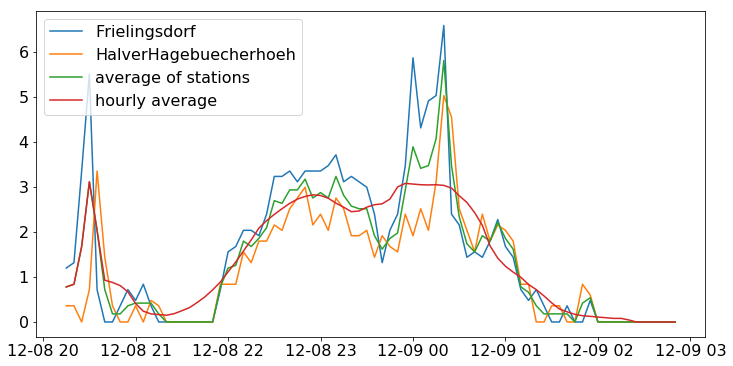

In [108]:
st0 = load_station(stations[0])
print(st0.shape)
fig = pl.figure(figsize=(12,6))
ax = fig.add_subplot(111)
#ax.plot(st0['Time'], st0['Rain'])
ax.plot(Time, s1, label=stations[0])
ax.plot(Time, s2, label=stations[1])
ax.plot(Time, St2m, label='average of stations')
ax.plot(Time, St2h, label='hourly average')
ax.legend()

#ax.set_ylim(0,4)

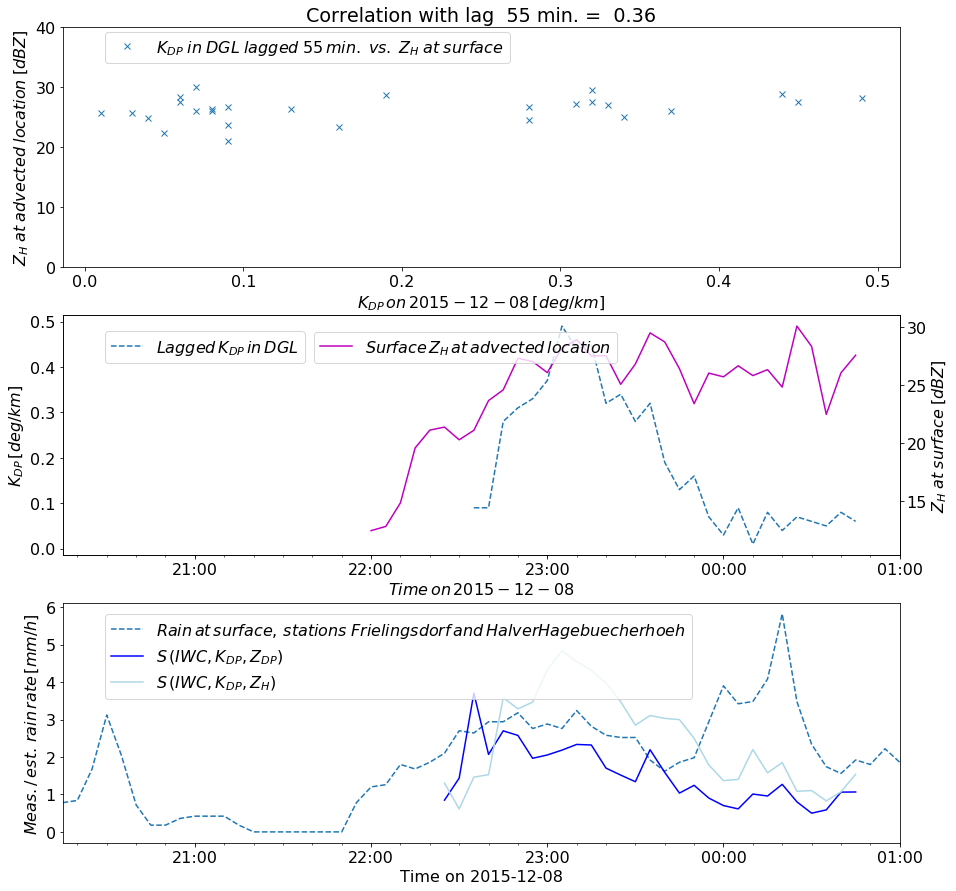

In [110]:
## ################One more similar plot with ZhSfc#######################
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator,DateFormatter, drange
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig3, ax = pl.subplots(3, figsize=(15, 15))
ax[0].plot(KDP_D, zh_at_loc[highlag:len(KDP_D)+highlag], 'x', label=r'$K_{DP}\; in\; DGL\; lagged\; %2.0f \,min. \; vs.\;Z_H\; at\; surface$' % (highlag*5))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, bbox_to_anchor=(0.05, 0.85), loc=[1,0], borderaxespad=0.)
ax[0].set_ylabel(r"$Z_H\; at\; advected\; location\; [dBZ]$")
ax[0].set_xlabel(r"$K_{DP}\, on\, %s \, [deg/km]$" % (date))
ax[0].set_title("Correlation with lag %3.0f min. = %5.2f" % (highlag*5, highcorr))
ax[0].set_ylim([0,40])

ax[1].plot(Time2, KDP_D, '--', label = r'$Lagged\, K_{DP}\, in\, DGL$')
ax2=ax[1].twinx()
ax2.xaxis.set_major_locator(HourLocator())
ax2.xaxis.set_minor_locator(MinuteLocator(np.arange(0, 60, 10)))
ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax2.plot(Time2, zh_at_loc[highlag:len(KDP_D)+highlag], 'm', label = r'$Surface\, Z_{H}\, at\, advected\, location$')
ax[1].set_ylabel(r"$K_{DP}\, [deg/km]$")
ax[1].set_xlabel(r"$Time\, on\, %s $" % (date))
ax2.set_ylabel(r"$Z_{H}\; at\; surface\; [dBZ]$")
handles, labels = ax[1].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax[1].legend(handles, labels, bbox_to_anchor=(0.05, 0.8), loc=[0,1], borderaxespad=0.)
ax2.legend(handles2, labels2, bbox_to_anchor=(0.3, 0.8), loc=[0,1], borderaxespad=0.)
ax[1].set_xlim(['2015-12-08 20:15:00','2015-12-09 01:00:00'])



ax[2].plot(Time, St2m, '--', label = r'$Rain\, at\, surface,\, stations\; %s \, and\, %s $' % (stations[0], stations[1]))
ax[2].plot(Time2, R_IWC_D, 'blue', label=r'$S\,(IWC, K_{DP}, Z_{DP})$')
ax[2].plot(Time2, R_IWC2_D, 'lightblue', label=r'$S\,(IWC, K_{DP}, Z_{H})$')
ax[2].xaxis.set_major_locator(HourLocator())
ax[2].xaxis.set_minor_locator(MinuteLocator(np.arange(0, 60, 10)))
ax[2].xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax[2].set_ylabel(r"$Meas./\,est.\,rain\, rate\, [mm/h]$")
ax[2].set_xlabel("Time on %s" % (date))
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles, labels, bbox_to_anchor=(0.05, 0.6), loc=[0,1], borderaxespad=0.)
ax[2].set_xlim(['2015-12-08 20:15:00','2015-12-09 01:00:00'])

fig3.savefig(plot_path + date + 'V3.png')
pl.show()